In [1]:
# import zipfile
# from pathlib import Path

# # Use existing variables if available in the notebook environment:
# # zip_path : Path to the zip (e.g., PosixPath('data/noaudio_ver3.zip'))
# # extract_dir : Path where to extract (e.g., PosixPath('data'))

# # Fallbacks if those names aren't defined when this cell runs:
# try:
#     zip_path  # noqa: F821
# except NameError:
#     zip_path = Path("data/noaudio_ver3.zip")

# try:
#     extract_dir  # noqa: F821
# except NameError:
#     extract_dir = Path("data")

# extract_dir = Path(extract_dir)
# extract_dir.mkdir(parents=True, exist_ok=True)

# with zipfile.ZipFile(zip_path, "r") as z:
#     z.extractall(path=extract_dir)
#     extracted = z.namelist()

# print(f"Extracted {len(extracted)} items to: {extract_dir}")

In [2]:
# %pip install ultralytics
# %pip install opencv-python #for cv2

# 1. Imports and Configuration

In [3]:
import os
import re
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from pathlib import Path
from typing import List, Tuple, Dict

# Configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Hyperparameters
NUM_CLASSES = 3
SEQ_LEN = 64          # Length of the frame sequence to feed the model
FRAME_SIZE = 224      # Input size (224х224 as in ResNet)
FEATURE_DIM = 128      # Output of the CNN encoder
CHANNELS = [64, 64, 64, 64]   # TCN layers, number of channels per layer
KERNEL_SIZE = 5     # TCN kernel size, affects the "Receptive Field"
DROPOUT = 0.2      # TCN dropout, helps with regularization preventing overfitting on deeper nets
BATCH_SIZE = 16     # Batch size, Stabilizes the fluctuating validation accuracy.
LR = 1e-3
EPOCHS = 25
ACCUM_STEPS = 4  # Simulates Batch Size = 8 * 4 = 32

# Mapping
CLASS_MAP = {'Rock': 0, 'Paper': 1, 'Scissor': 2}
INV_CLASS_MAP = {0: 'Rock', 1: 'Paper', 2: 'Scissor'}
WINNING_MOVE = {
    'Rock': 'Paper',
    'Paper': 'Scissor',
    'Scissor': 'Rock'
}

Using device: cuda


# 2. The Dataset Loader (Fixed for this current file structure)

In [4]:
class VideoFramesDataset(Dataset):
    def __init__(self, root_dir: str, seq_len: int = 16, augment: bool = False):
        self.root = Path(root_dir)
        self.seq_len = seq_len
        self.augment = augment
        
        # Transforms
        if augment:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)), # Bump resolution up
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15), # Rotates hand +/- 15 degrees
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                transforms.ToTensor(),
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize((FRAME_SIZE, FRAME_SIZE)),
                transforms.ToTensor(),
            ])

        self.samples = self._parse_filesystem()

    def _parse_filesystem(self) -> List[Tuple[List[Path], int]]:
        """Parses the directory to group frames into video sequences."""
        samples = []
        # Regex to capture: (VideoID)_(FrameNumber).jpg
        # Example: 20251122_220625_720p20fps_nosound_095.jpg
        # Group 1 is the Video ID, Group 2 is the frame index.
        pattern = re.compile(r'(.+)_(\d+)\.(jpg|jpeg|png)$', re.IGNORECASE)

        for cls_name, label in CLASS_MAP.items():
            cls_dir = self.root / cls_name
            # Handle slight naming variations (e.g. Scissor vs Scissors) if necessary
            if not cls_dir.exists():
                # Fallback check for plurals or lowercase if folder names vary
                cls_dir = self.root / (cls_name + 's') 
                if not cls_dir.exists():
                    print(f"Warning: Directory for {cls_name} not found.")
                    continue

            # Group frames by video ID
            video_frames: Dict[str, List[Tuple[int, Path]]] = {}
            
            for img_path in cls_dir.glob('*'):
                match = pattern.match(img_path.name)
                if match:
                    vid_id = match.group(1)
                    frame_idx = int(match.group(2))
                    if vid_id not in video_frames:
                        video_frames[vid_id] = []
                    video_frames[vid_id].append((frame_idx, img_path))

            # Process grouped frames into sequences
            for vid_id, frames in video_frames.items():
                # Sort by frame index
                frames.sort(key=lambda x: x[0])
                paths = [p for _, p in frames]
                
                # We can create multiple sliding windows or just take the end
                # Here, we take the last SEQ_LEN frames to capture the gesture formation
                if len(paths) >= self.seq_len:
                    # Optional: sliding window for more data
                    # for i in range(len(paths) - self.seq_len + 1):
                    #     samples.append((paths[i : i+self.seq_len], label))
                    
                    # Simple version: Take the sequence
                    samples.append((paths[:self.seq_len], label)) 
                else:
                    # Pad if video is too short (repeat first frame)
                    padded = [paths[0]] * (self.seq_len - len(paths)) + paths
                    samples.append((padded, label))
                    
        print(f"Found {len(samples)} sequences.")
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        frame_paths, label = self.samples[idx]
        images = []
        for p in frame_paths:
            img = Image.open(p).convert('RGB')
            images.append(self.transform(img))
        
        # Stack: (Seq_Len, Channels, Height, Width)
        seq_tensor = torch.stack(images, dim=0)
        return seq_tensor, label

# 3. The Model (CNN + TCN)

In [5]:
# Try importing TCN, handle if not installed
try:
    from pytorch_tcn import TCN
except ImportError:
    print("pytorch-tcn not found. Please run: pip install pytorch-tcn")

import torchvision.models as models

class ResNetFrameEncoder(nn.Module):
    def __init__(self, feature_dim=64):
        super().__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        
        # Keep the first few layers frozen (they detect simple edges/lines)
        for param in resnet.parameters():
            param.requires_grad = False
            
        # UNFREEZE the last residual block (layer4)
        # This layer learns complex shapes like "fingers" and "fists"
        for param in resnet.layer4.parameters():
            param.requires_grad = True
            
        modules = list(resnet.children())[:-1] 
        self.backbone = nn.Sequential(*modules)
        self.proj = nn.Linear(512, feature_dim)

    def forward(self, x):
        # We need BatchNorm to update stats for the unfrozen layers
        self.backbone.train() 
        features = self.backbone(x)
        features = features.flatten(1)
        return self.proj(features)
    
    
class GestureTCN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.encoder = ResNetFrameEncoder(feature_dim=FEATURE_DIM) 
        
        self.tcn = TCN(
            num_inputs=FEATURE_DIM,
            num_channels=CHANNELS,
            kernel_size=KERNEL_SIZE,
            dropout=DROPOUT,
            causal=True,
            input_shape='NCL' 
        )
        self.classifier = nn.Linear(CHANNELS[-1], num_classes)

    def forward(self, x, return_all_timesteps=False):
        # x: (Batch, Seq_Len, 3, H, W)
        b, t, c, h, w = x.shape
        x_flat = x.view(b * t, c, h, w)
        
        features = self.encoder(x_flat)      # (B*T, Feat)
        features = features.view(b, t, -1).permute(0, 2, 1) # (B, Feat, T) for TCN
        
        tcn_out = self.tcn(features)         # (B, Hidden, T)
        
        if return_all_timesteps:
            # Transpose to (B, T, Hidden) so Linear layer applies to every step
            tcn_out = tcn_out.permute(0, 2, 1) 
            return self.classifier(tcn_out)  # Returns (B, T, Num_Classes)
        else:
            # Standard training behavior (last step only)
            last_out = tcn_out[:, :, -1]
            return self.classifier(last_out) # Returns (B, Num_Classes)

# 4. Training Loop

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# --- HELPER: Time Weights (Sigmoid) ---
def time_weights(T, mode='sigmoid', alpha=2.0):
    t = torch.linspace(0, 1, steps=T)
    if mode == 'linear':
        w = 0.1 + 0.9 * t
    elif mode == 'sigmoid':
        # S-curve centered at T/2. Alpha controls steepness.
        x = (t - 0.5) * alpha * 10 
        w = torch.sigmoid(x)
    else:
        w = torch.ones(T)
    # Normalize so sum equals T (keeps loss magnitude consistent)
    w = w / w.sum() * T
    return w.to(DEVICE)

# --- MAIN TRAINING FUNCTION ---
def train_model(data_path_train=None, data_path_val=None):
    # Update paths to your dataset
    dataset_train = VideoFramesDataset(data_path_train, seq_len=SEQ_LEN, augment=True)
    dataset_val = VideoFramesDataset(data_path_val, seq_len=SEQ_LEN, augment=True)
    
    # BATCH_SIZE can now be small (e.g., 8) because we accumulate gradients
    train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)
    
    model = GestureTCN(num_classes=NUM_CLASSES).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    
    # Scheduler to lower LR near the end
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    # Loss reduction='none' so we can apply custom time weights
    criterion = nn.CrossEntropyLoss(reduction='none') 
    
    # --- CONFIG FOR GRADIENT ACCUMULATION ---
    # Effective Batch Size = BATCH_SIZE * ACCUM_STEPS
    # Example: 8 * 4 = 32
    ACCUM_STEPS = 4  
    
    print(f"Starting training with Gradient Accumulation (Steps={ACCUM_STEPS})...")
    
    # Pre-calculate time weights once
    weights = time_weights(SEQ_LEN, mode='sigmoid', alpha=2.0)
    
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        # Initialize gradients to zero at start of epoch
        optimizer.zero_grad()
        
        # Use enumerate to track batch index 'i'
        for i, (frames, labels) in enumerate(train_loader):
            frames, labels = frames.to(DEVICE), labels.to(DEVICE)
            
            # 1. Forward Pass (Get output for all 64 frames)
            outputs_all_steps = model(frames, return_all_timesteps=True)
            
            # 2. Calculate Weighted Loss
            # Reshape to (Batch*T, Classes) for CrossEntropy
            loss_per_frame = criterion(
                outputs_all_steps.view(-1, NUM_CLASSES), 
                labels.repeat_interleave(SEQ_LEN)
            )
            
            # Reshape back to (Batch, T) and apply weights
            loss_per_frame = loss_per_frame.view(-1, SEQ_LEN)
            weighted_loss = (loss_per_frame * weights).mean()
            
            # --- GRADIENT ACCUMULATION LOGIC ---
            
            # Normalize loss to account for the accumulation
            # (mathematically equivalent to averaging over the larger effective batch)
            weighted_loss = weighted_loss / ACCUM_STEPS 
            
            # Accumulate gradients (they add up in .grad attributes)
            weighted_loss.backward()
            
            # Step ONLY every 'ACCUM_STEPS' batches
            if (i + 1) % ACCUM_STEPS == 0:
                optimizer.step()
                optimizer.zero_grad() # Clear gradients for the next set of accumulation
            
            # -----------------------------------
            
            # Track metrics (multiply loss back by ACCUM_STEPS for correct reporting)
            train_loss += weighted_loss.item() * ACCUM_STEPS
            
            # Accuracy on last frame
            final_output = outputs_all_steps[:, -1, :]
            _, predicted = final_output.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        # Step the scheduler at the end of the epoch
        scheduler.step()
            
        print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {train_loss/len(train_loader):.4f} | Acc: {100.*correct/total:.2f}%")
        
        # --- VALIDATION LOOP ---
        model.eval() 
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for frames, labels in val_loader:
                frames, labels = frames.to(DEVICE), labels.to(DEVICE)
                outputs = model(frames, return_all_timesteps=False) # Only last frame needed
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
            
        print(f"Epoch {epoch+1}/{EPOCHS} | Val Acc: {100.*val_correct/val_total:.2f}%")
        
    torch.save(model.state_dict(), 'rps_tcn_model.pth')
    print("Model saved.")
    return model

# Run it
model = train_model(data_path_train='data/final_split_dataset/train', data_path_val='data/final_split_dataset/val')

Found 60 sequences.
Found 11 sequences.
Starting training with Gradient Accumulation (Steps=4)...
Epoch 1/25 | Loss: 1.2135 | Acc: 36.67%
Epoch 1/25 | Val Acc: 63.64%
Epoch 2/25 | Loss: 0.9395 | Acc: 65.00%
Epoch 2/25 | Val Acc: 81.82%
Epoch 3/25 | Loss: 0.3262 | Acc: 86.67%
Epoch 3/25 | Val Acc: 100.00%
Epoch 4/25 | Loss: 0.0646 | Acc: 100.00%
Epoch 4/25 | Val Acc: 100.00%
Epoch 5/25 | Loss: 0.0770 | Acc: 100.00%
Epoch 5/25 | Val Acc: 100.00%
Epoch 6/25 | Loss: 0.0263 | Acc: 100.00%
Epoch 6/25 | Val Acc: 100.00%
Epoch 7/25 | Loss: 0.0299 | Acc: 100.00%
Epoch 7/25 | Val Acc: 100.00%
Epoch 8/25 | Loss: 0.0229 | Acc: 100.00%
Epoch 8/25 | Val Acc: 100.00%
Epoch 9/25 | Loss: 0.0294 | Acc: 100.00%
Epoch 9/25 | Val Acc: 100.00%
Epoch 10/25 | Loss: 0.0239 | Acc: 100.00%
Epoch 10/25 | Val Acc: 100.00%
Epoch 11/25 | Loss: 0.0211 | Acc: 100.00%
Epoch 11/25 | Val Acc: 100.00%
Epoch 12/25 | Loss: 0.0136 | Acc: 100.00%
Epoch 12/25 | Val Acc: 100.00%
Epoch 13/25 | Loss: 0.0269 | Acc: 100.00%
Epoch 1

# 5. The "Winning" Inference Logic

In [7]:
def predict_move(model, sequence_buffer):
    """
    Takes a sequence of frames (Tensor) and predicts the user's move.
    Then returns the move that BEATS the user.
    """
    model.eval()
    with torch.no_grad():
        # Input shape: (1, Seq_Len, 3, H, W)
        frames = sequence_buffer.to(DEVICE)
        logits = model(frames)
        probs = torch.softmax(logits, dim=1)
        
        # Get the predicted class (what the user is doing)
        confidence, pred_idx = torch.max(probs, 1)
        user_move = INV_CLASS_MAP[pred_idx.item()]
        
        # Logic to beat the user
        my_move = WINNING_MOVE[user_move]
        
        return user_move, my_move, confidence.item()

# Example usage (simulated):
# seq = torch.randn(1, 16, 3, 128, 128) # Replace with real camera buffer
# user_gesture, counter_move, conf = predict_move(model, seq)
# print(f"User is showing {user_gesture}. I play {counter_move} to win!")

# 6. Evalutaing

/home/default/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Loading data from: data/final_split_dataset/test
Found 15 sequences.
Found 15 video sequences.
Weights loaded successfully.

Final Accuracy (at frame 64): 86.67%
The model reaches 80% accuracy at Frame 51!


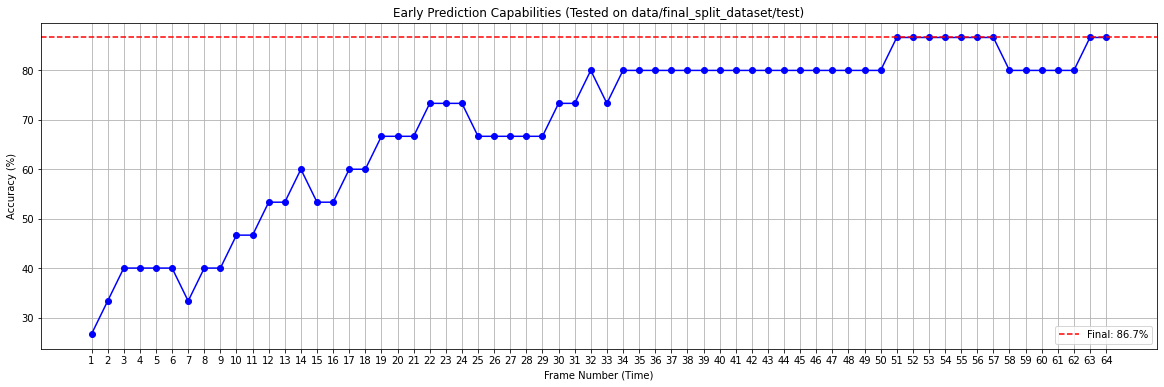

In [8]:
import matplotlib.pyplot as plt

def evaluate_on_new_data(model_path, data_path):
    print(f"Loading data from: {data_path}")
    
    # 1. Create Dataset for the NEW folder
    # We use augment=False because this is a test run
    test_ds = VideoFramesDataset(data_path, seq_len=SEQ_LEN, augment=False)
    test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)
    
    print(f"Found {len(test_ds)} video sequences.")

    # 2. Load Model
    model = GestureTCN(num_classes=NUM_CLASSES).to(DEVICE)
    try:
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
        print("Weights loaded successfully.")
    except FileNotFoundError:
        print("Error: Model file not found. Make sure you trained it first!")
        return

    model.eval()
    
    # 3. Metrics Storage
    # We want to know: "What is the accuracy at Frame 1? Frame 2? ... Frame 16?"
    correct_at_frame = [0] * SEQ_LEN
    total_samples = 0
    
    with torch.no_grad():
        for seq, labels in test_loader:
            seq = seq.to(DEVICE)
            labels = labels.to(DEVICE)
            
            # Get output for ALL timesteps: Shape (Batch, 16, 3)
            logits_all_steps = model(seq, return_all_timesteps=True)
            
            # Convert to predictions
            preds_all_steps = logits_all_steps.argmax(dim=2) # Shape (Batch, 16)
            
            # Check accuracy for each timestep
            for t in range(SEQ_LEN):
                # How many in this batch got frame 't' correct?
                correct_at_frame[t] += (preds_all_steps[:, t] == labels).sum().item()
            
            total_samples += labels.size(0)

    # 4. Calculate Percentages
    accuracies = [ (c / total_samples) * 100 for c in correct_at_frame ]
    
    # 5. Report Results
    final_acc = accuracies[-1]
    print(f"\nFinal Accuracy (at frame {SEQ_LEN}): {final_acc:.2f}%")
    
    # Find "Early Prediction" point (e.g., when acc > 80%)
    early_point = next((i for i, x in enumerate(accuracies) if x > 80.0), None)
    if early_point:
        print(f"The model reaches 80% accuracy at Frame {early_point + 1}!")
    else:
        print("The model did not reach 80% accuracy.")

    # 6. Plot
    plt.figure(figsize=(20, 6))
    plt.plot(range(1, SEQ_LEN+1), accuracies, marker='o', linestyle='-', color='b')
    plt.axhline(y=final_acc, color='r', linestyle='--', label=f'Final: {final_acc:.1f}%')
    plt.title(f'Early Prediction Capabilities (Tested on {data_path})')
    plt.xlabel('Frame Number (Time)')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.xticks(range(1, SEQ_LEN+1))
    plt.legend()
    plt.show()

# --- RUN THE TEST ---
# Ensure 'rps_tcn_model.pth' exists (or whatever you named your saved model)
# Point to your NEW data folder
evaluate_on_new_data(model_path='rps_tcn_model.pth', data_path='data/final_split_dataset/test')

Found 15 sequences.


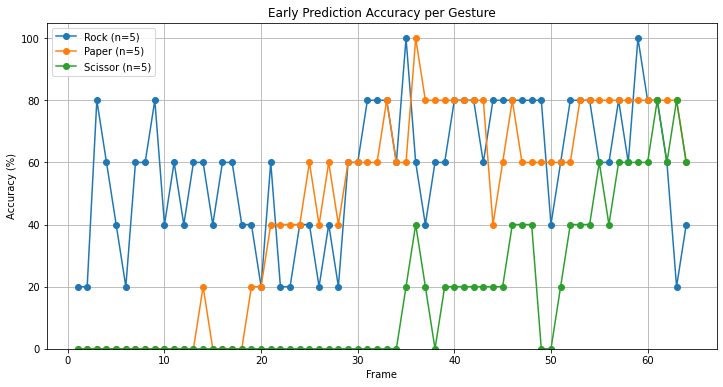

In [11]:
def evaluate_per_class(model_path, data_path):
    # Load Model
    model = GestureTCN(num_classes=NUM_CLASSES).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()
    
    # Load Data
    dataset = VideoFramesDataset(data_path, seq_len=SEQ_LEN, augment=False)
    loader = DataLoader(dataset, batch_size=1, shuffle=False) # Batch size 1 to track individual files
    
    # Storage
    # Dictionary: {'Rock': [1, 0, 0...], 'Paper': ...}
    # 1 = Correct at that frame, 0 = Wrong
    results = {0: [], 1: [], 2: []} 
    counts = {0: 0, 1: 0, 2: 0}
    
    class_map_rev = {0: 'Rock', 1: 'Paper', 2: 'Scissor'}

    with torch.no_grad():
        for seq, label in loader:
            seq, label = seq.to(DEVICE), label.to(DEVICE)
            lbl_idx = label.item()
            
            # Get predictions for all timesteps
            logits = model(seq, return_all_timesteps=True)
            preds = logits.argmax(dim=2).squeeze(0) # (Seq_Len,)
            
            # Check correctness per frame
            # [1, 1, 0, 1...]
            is_correct = (preds == lbl_idx).cpu().numpy().astype(int)
            
            if counts[lbl_idx] == 0:
                results[lbl_idx] = is_correct
            else:
                results[lbl_idx] += is_correct # Accumulate
            
            counts[lbl_idx] += 1
            
    # Plotting
    plt.figure(figsize=(12, 6))
    
    for cls_idx in [0, 1, 2]:
        if counts[cls_idx] > 0:
            # Average over all videos of this class
            avg_acc = (results[cls_idx] / counts[cls_idx]) * 100
            label_name = class_map_rev[cls_idx]
            plt.plot(range(1, SEQ_LEN+1), avg_acc, marker='o', label=f'{label_name} (n={counts[cls_idx]})')

    plt.title('Early Prediction Accuracy per Gesture')
    plt.xlabel('Frame')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 105)
    plt.show()

# Run it
evaluate_per_class('rps_tcn_model.pth', 'data/final_split_dataset/test')

Found 15 sequences.


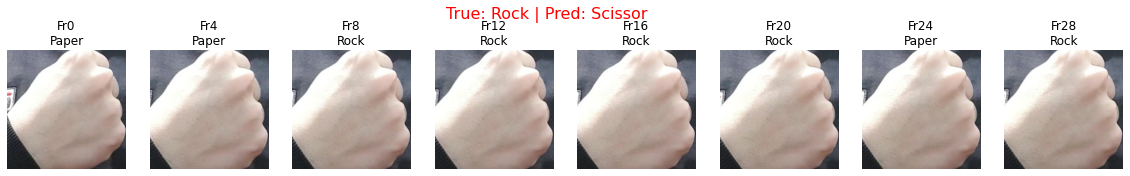

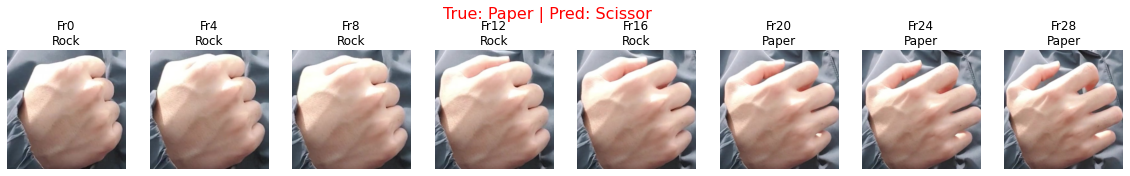

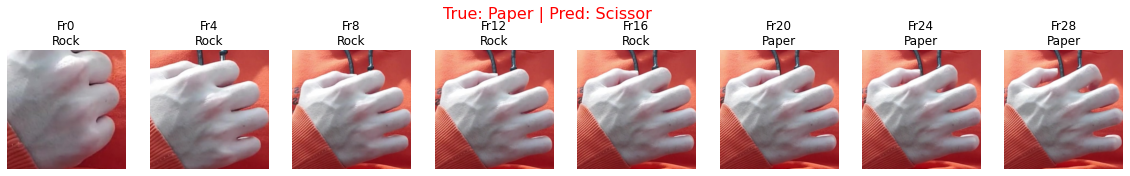

In [10]:
def visualize_failures(model_path, data_path):
    model = GestureTCN(num_classes=NUM_CLASSES).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()
    
    dataset = VideoFramesDataset(data_path, seq_len=SEQ_LEN, augment=False)
    loader = DataLoader(dataset, batch_size=1, shuffle=True)
    
    class_map_rev = {0: 'Rock', 1: 'Paper', 2: 'Scissor'}
    
    count = 0
    
    with torch.no_grad():
        for seq, label in loader:
            seq = seq.to(DEVICE)
            logits = model(seq, return_all_timesteps=True)
            preds = logits.argmax(dim=2).squeeze(0)
            
            # Check if the FINAL prediction was wrong
            if preds[-1].item() != label.item():
                # IT FAILED! Let's visualize.
                
                # 1. Un-normalize/Convert tensors to images
                fig, axes = plt.subplots(1, 8, figsize=(20, 3)) # Show every 2nd frame (8 total)
                fig.suptitle(f"True: {class_map_rev[label.item()]} | Pred: {class_map_rev[preds[-1].item()]}", fontsize=16, color='red')
                
                for i, ax in enumerate(axes):
                    frame_idx = i * 4 # 0, 4, 8, 12... (if seq_len=32)
                    if frame_idx >= SEQ_LEN: break
                    
                    img_tensor = seq[0, frame_idx].cpu()
                    img = transforms.ToPILImage()(img_tensor)
                    
                    ax.imshow(img)
                    ax.set_title(f"Fr{frame_idx}\n{class_map_rev[preds[frame_idx].item()]}")
                    ax.axis('off')
                
                plt.show()
                count += 1
                if count >= 3: break # Show only top 3 failures

# Run it
visualize_failures('rps_tcn_model.pth', 'data/final_split_dataset/test')